# Дашборд конверсий

In [212]:
import pandas as pd
import numpy as np
import requests
import os
from dotenv import load_dotenv
from pathlib import Path

### Запрос к API

In [213]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [214]:
visit_json = requests.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")
v = visit_json.json()
df_visits = pd.DataFrame(v)
df_visits.head()

,datetime,platform,user_agent,visit_id
0,"Wed, 01 Mar 2023 10:36:22 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1de9ea66-70d3-4a1f-8735-df5ef7697fb9
1,"Wed, 01 Mar 2023 06:25:00 GMT",web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,f149f542-e935-4870-9734-6b4501eaf614
2,"Wed, 01 Mar 2023 10:26:13 GMT",web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1
3,"Wed, 01 Mar 2023 12:33:06 GMT",web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,19322fed-157c-49c6-b16e-2d5cabeb9592
4,"Wed, 01 Mar 2023 01:38:35 GMT",web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,04762a22-3c9f-40c9-9ac9-6628c4381836


In [215]:
registration_json = requests.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")
r = registration_json.json()
df_reg = pd.DataFrame(r)
df_reg.head()

,datetime,email,platform,registration_type,user_id
0,"Wed, 01 Mar 2023 07:40:13 GMT",ebyrd@example.org,web,google,2e0f6bb8-b029-4f45-a786-2b53990d37f1
1,"Wed, 01 Mar 2023 13:14:00 GMT",knightgerald@example.org,web,email,f007f97c-9d8b-48b5-af08-119bb8f6d9b6
2,"Wed, 01 Mar 2023 03:05:50 GMT",cherylthompson@example.com,web,apple,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15
3,"Wed, 01 Mar 2023 00:04:47 GMT",halldavid@example.org,web,email,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60
4,"Wed, 01 Mar 2023 18:31:52 GMT",denise86@example.net,web,google,27f875fc-f8ce-4aeb-8722-0ecb283d0760


In [216]:
#visits = requests.get('https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01')
#registrations = requests.get('https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01')

### Расчет метрик

In [217]:
df_v = df_visits.copy()
df_v['datetime'] = pd.to_datetime(df_v['datetime'])
df_v = df_v.sort_values(by=['visit_id', 'datetime']).drop_duplicates(subset=['visit_id'], keep='last')
df_v = df_v[~df_v['user_agent'].str.contains('bot')]
df_v['date_group'] = df_v['datetime'].dt.to_period('D').dt.start_time.dt.date
visits_grouped = df_v.groupby(['date_group', 'platform']).size().reset_index(name='visits')

df_reg = df_reg.drop_duplicates()
df_reg['datetime'] = pd.to_datetime(df_reg['datetime'])
df_reg['platform'] = df_reg['platform'].fillna('web')
df_reg['date_group'] = df_reg['datetime'].dt.to_period('D').dt.start_time.dt.date
registrations_grouped = df_reg.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

merged_df = pd.merge(visits_grouped, registrations_grouped, on=['date_group', 'platform'])
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']) * 100
merged_df.to_json('conversion.json')
merged_df.head(10)

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
5,2023-03-02,web,515,23,4.466019
6,2023-03-03,android,26,22,84.615385
7,2023-03-03,ios,40,34,85.000000
8,2023-03-03,web,617,51,8.265802
9,2023-03-04,android,94,77,81.914894


Рекламы

In [218]:
url = 'https://github.com/Filippova-Anna/data-analytics-project-100/blob/main/ads.csv?raw=true'
ads = pd.read_csv(url)
ads.head()

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01T10:54:41,google,cpc,advanced_algorithms_series,212
1,2023-03-02T10:32:35,google,cpc,advanced_algorithms_series,252
2,2023-03-03T19:21:40,google,cpc,advanced_algorithms_series,202
3,2023-03-04T17:52:04,google,cpc,advanced_algorithms_series,223
4,2023-03-05T05:35:13,google,cpc,advanced_algorithms_series,265


In [219]:
ads = ads.drop_duplicates()
ads['date'] = pd.to_datetime(ads['date'], format='mixed')
ads['date'] = ads['date'].dt.to_period('D').dt.start_time.dt.date

ads = ads.sort_values(by='date')
ads['utm_campaign'] = ads['utm_campaign'].fillna('none')
ads['cost'] = ads['cost'].fillna('0')

df = pd.merge(merged_df, ads, left_on='date_group', right_on='date', how='left')
final_df = df[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
final_df.to_json('ads.json')
final_df.head()

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,75,61,212.0,advanced_algorithms_series
1,2023-03-01,22,18,212.0,advanced_algorithms_series
2,2023-03-01,279,8,212.0,advanced_algorithms_series
3,2023-03-02,67,59,252.0,advanced_algorithms_series
4,2023-03-02,31,24,252.0,advanced_algorithms_series


### Визуализация

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
grouped = df.copy()
grouped['date'] = pd.to_datetime(grouped['date_group'])
grouped['date'] = grouped['date'].dt.to_period('W').dt.start_time.dt.date
grouped_platform = grouped.groupby(['date', 'platform']).sum(['visits', 'registrations']).reset_index()
grouped_date = grouped.groupby(['date']).sum(['visits', 'registrations']).reset_index()
grouped_platform['conversion'] = (grouped_platform['registrations'] /grouped_platform['visits']) * 100
grouped_date['conversion'] = (grouped_date['registrations'] / grouped_date['visits']) * 100
grouped_date.head()

,date,visits,registrations,conversion,cost
0,2023-02-27,3026,574,18.968936,3462.0
1,2023-03-06,8615,1184,13.743471,3516.0
2,2023-03-13,5215,829,15.896453,1494.0
3,2023-03-20,3950,664,16.810127,1773.0
4,2023-03-27,4958,856,17.265026,3861.0


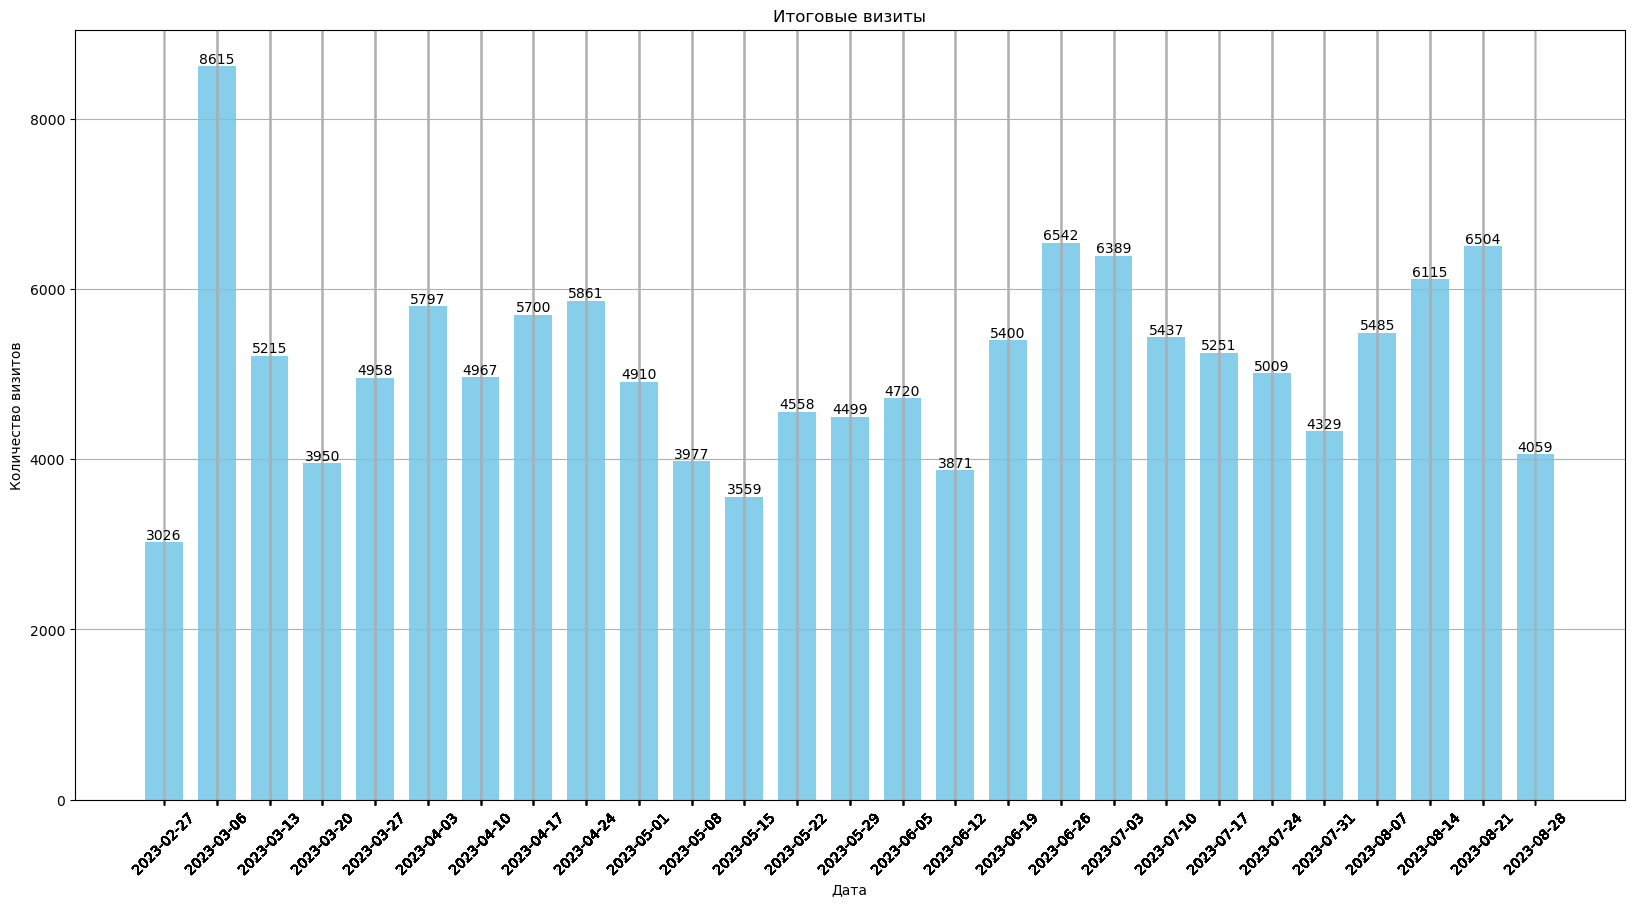

In [238]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(grouped_date['date'], grouped_date['visits'], color='skyblue', width=5)
plt.title('Итоговые визиты')
plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.xticks(grouped['date'], rotation=45)
plt.grid()
for bars in ax.containers:
    ax.bar_label(bars)
plt.savefig('./charts/total_visits.png')
plt.show()

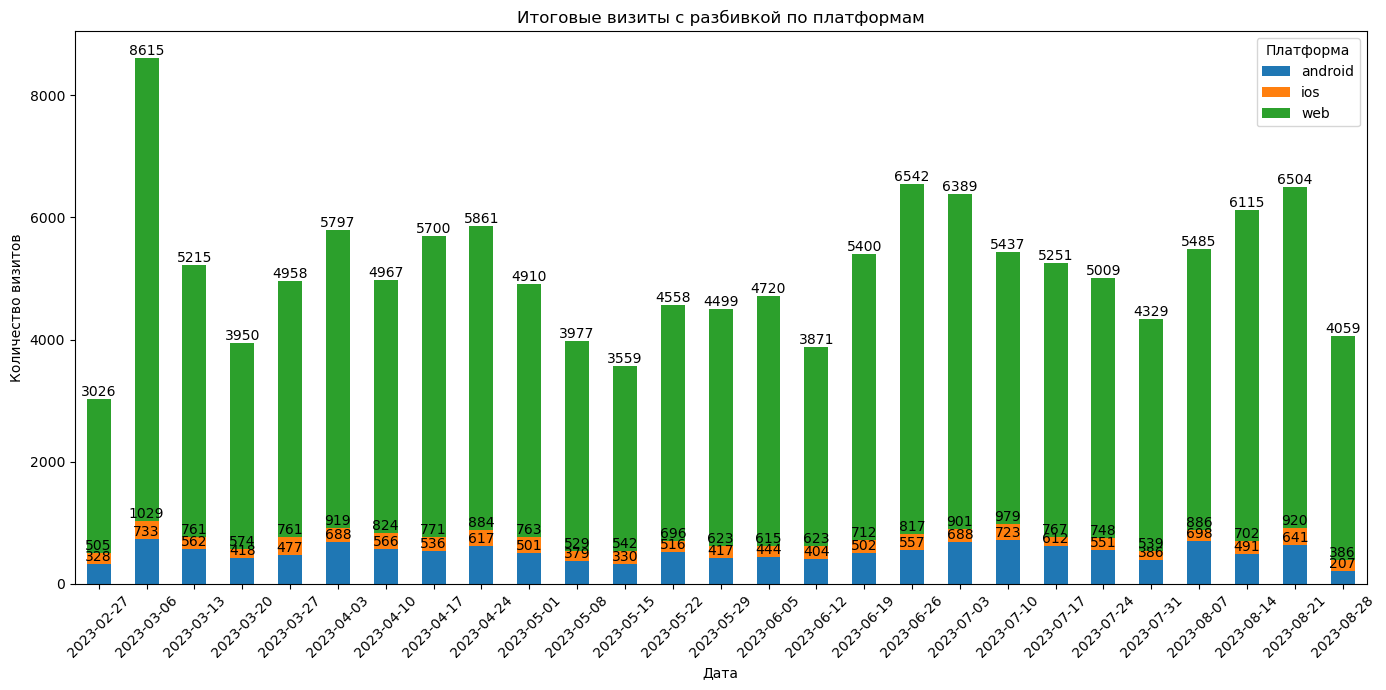

In [235]:
fig, ax = plt.subplots(figsize=(14,7))
plot = grouped_platform.pivot_table(index='date', columns='platform', values='visits')
plot.plot(kind='bar', stacked=True, ax=ax)
plt.title('Итоговые визиты с разбивкой по платформам')
plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.xticks(rotation=45)
plt.legend(title='Платформа')
plt.tight_layout()
for bars in ax.containers:
    ax.bar_label(bars)
plt.savefig('./charts/total_visits_by_platform_stacked_barplot.png')
plt.show()

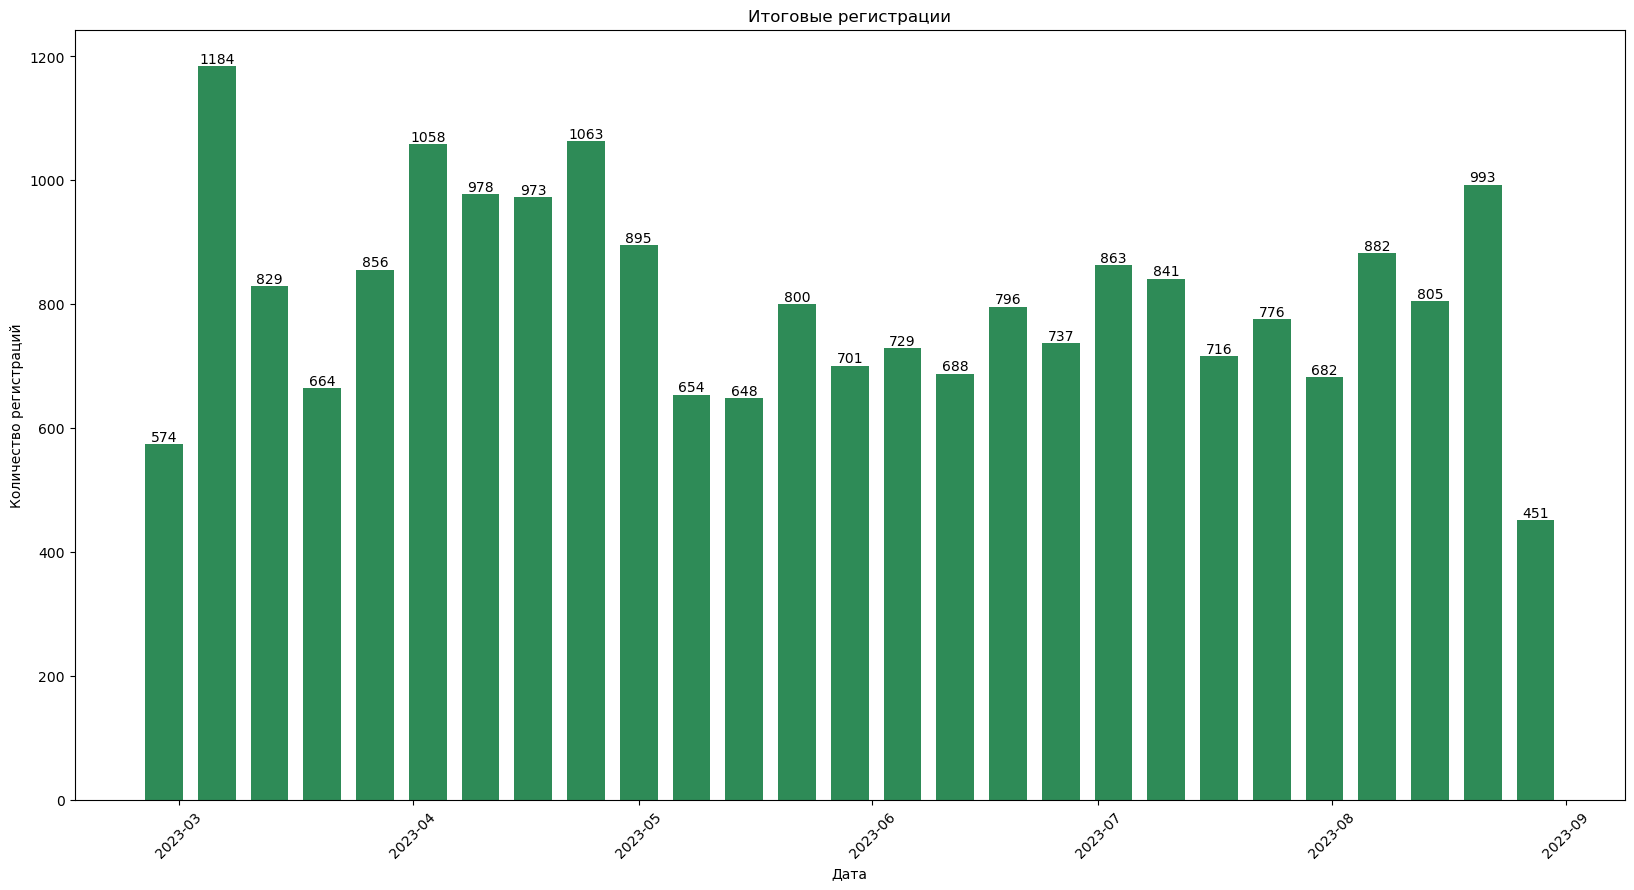

In [239]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(grouped_date['date'], grouped_date['registrations'], color='seagreen', width=5)
plt.title('Итоговые регистрации')
plt.xlabel('Дата')
plt.ylabel('Количество регистраций')
plt.xticks(rotation=45)
for bars in ax.containers:
    ax.bar_label(bars)
plt.savefig('./charts/total_registrations.png')
plt.show()

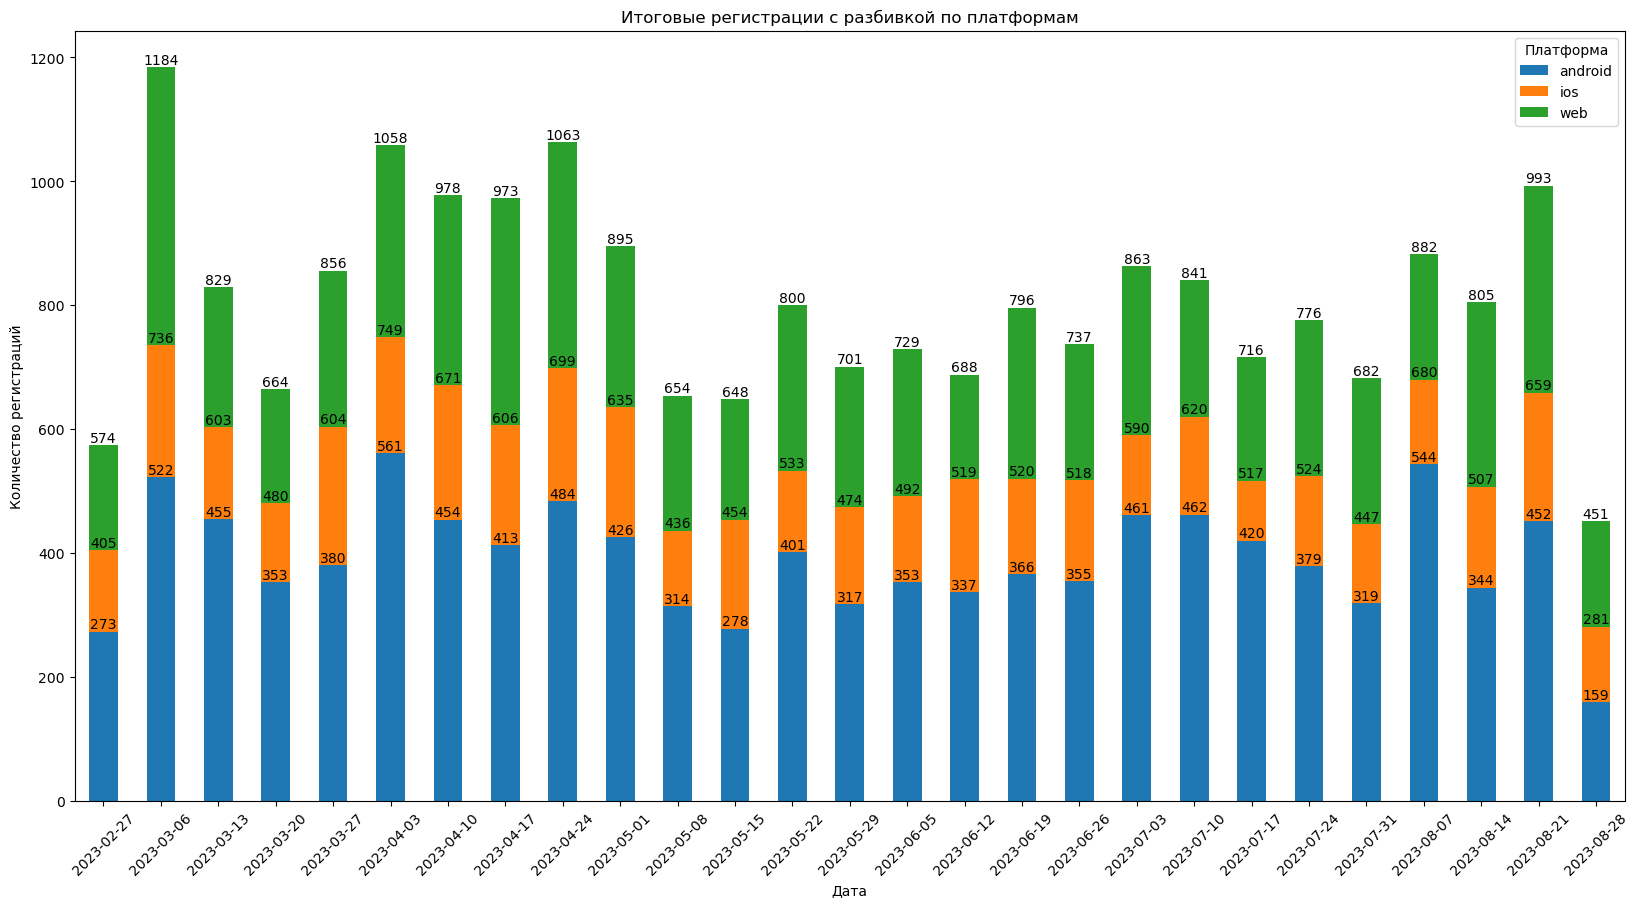

In [236]:
fig, ax = plt.subplots(figsize=(20,10))
plot_2 = grouped_platform.pivot_table(index='date', columns='platform', values='registrations')
plot_2.plot(kind='bar', stacked=True, ax=ax)
plt.title('Итоговые регистрации с разбивкой по платформам')
plt.xlabel('Дата')
plt.ylabel('Количество регистраций')
plt.xticks(rotation=45)
plt.legend(title='Платформа')
for bars in ax.containers:
    ax.bar_label(bars)
plt.savefig('./charts/total_registration_by_platform_stacked_barplot.png')
plt.show()

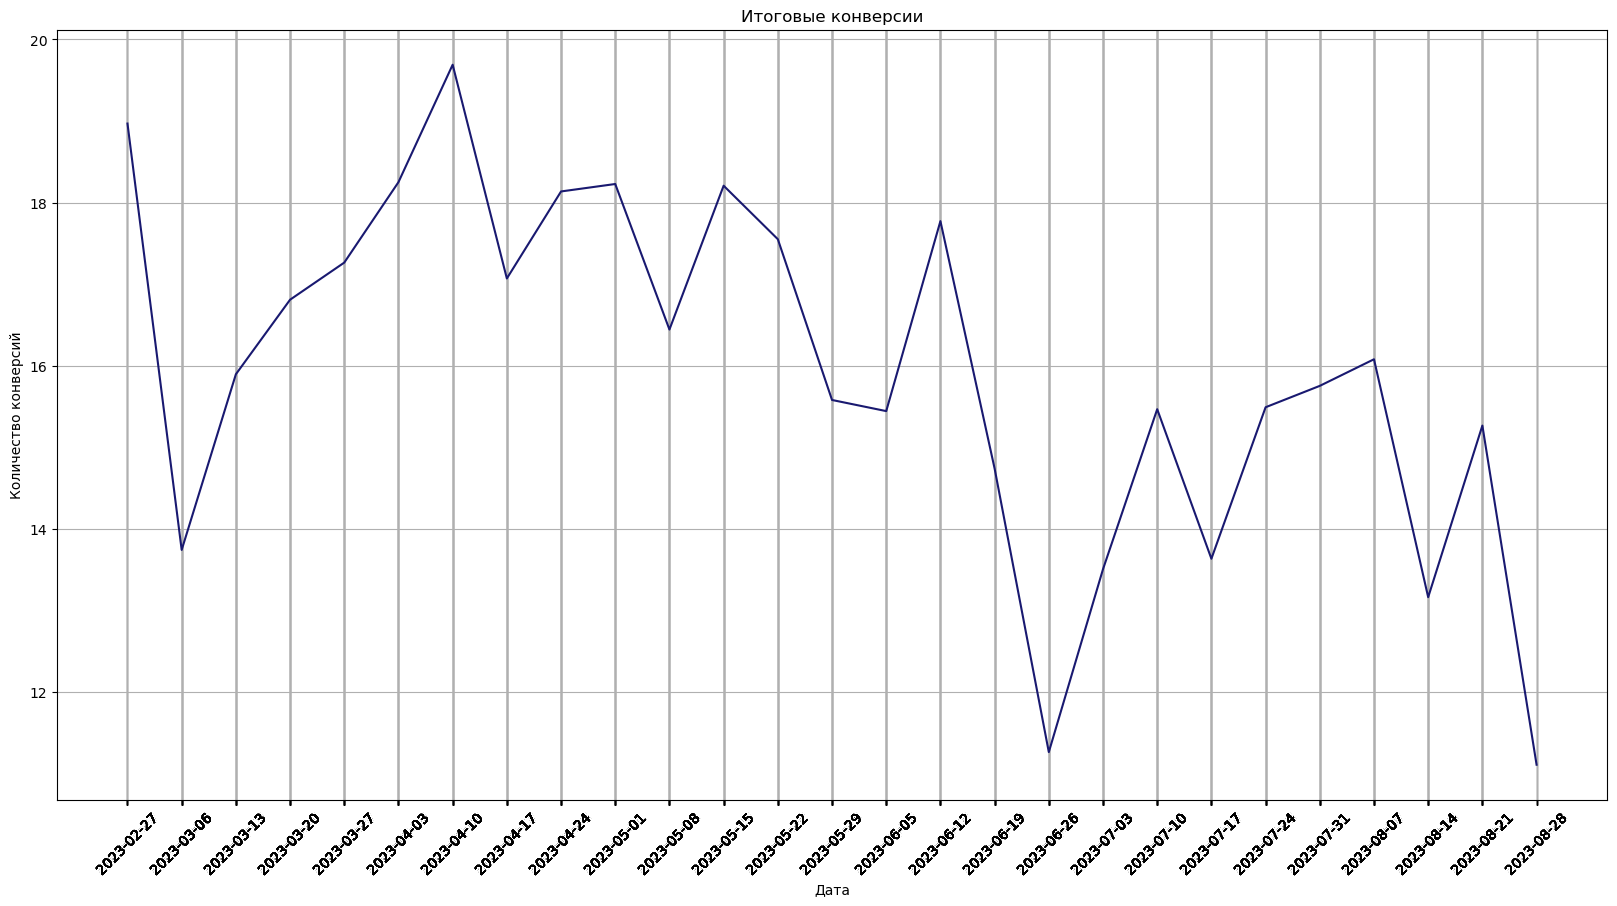

In [243]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(grouped_date['date'], grouped_date['conversion'], color='midnightblue')
plt.title('Итоговые конверсии')
plt.xlabel('Дата')
plt.ylabel('Количество конверсий')
plt.xticks(grouped['date'], rotation=45)
plt.grid()
plt.savefig('./charts/conversion.png')
plt.show()

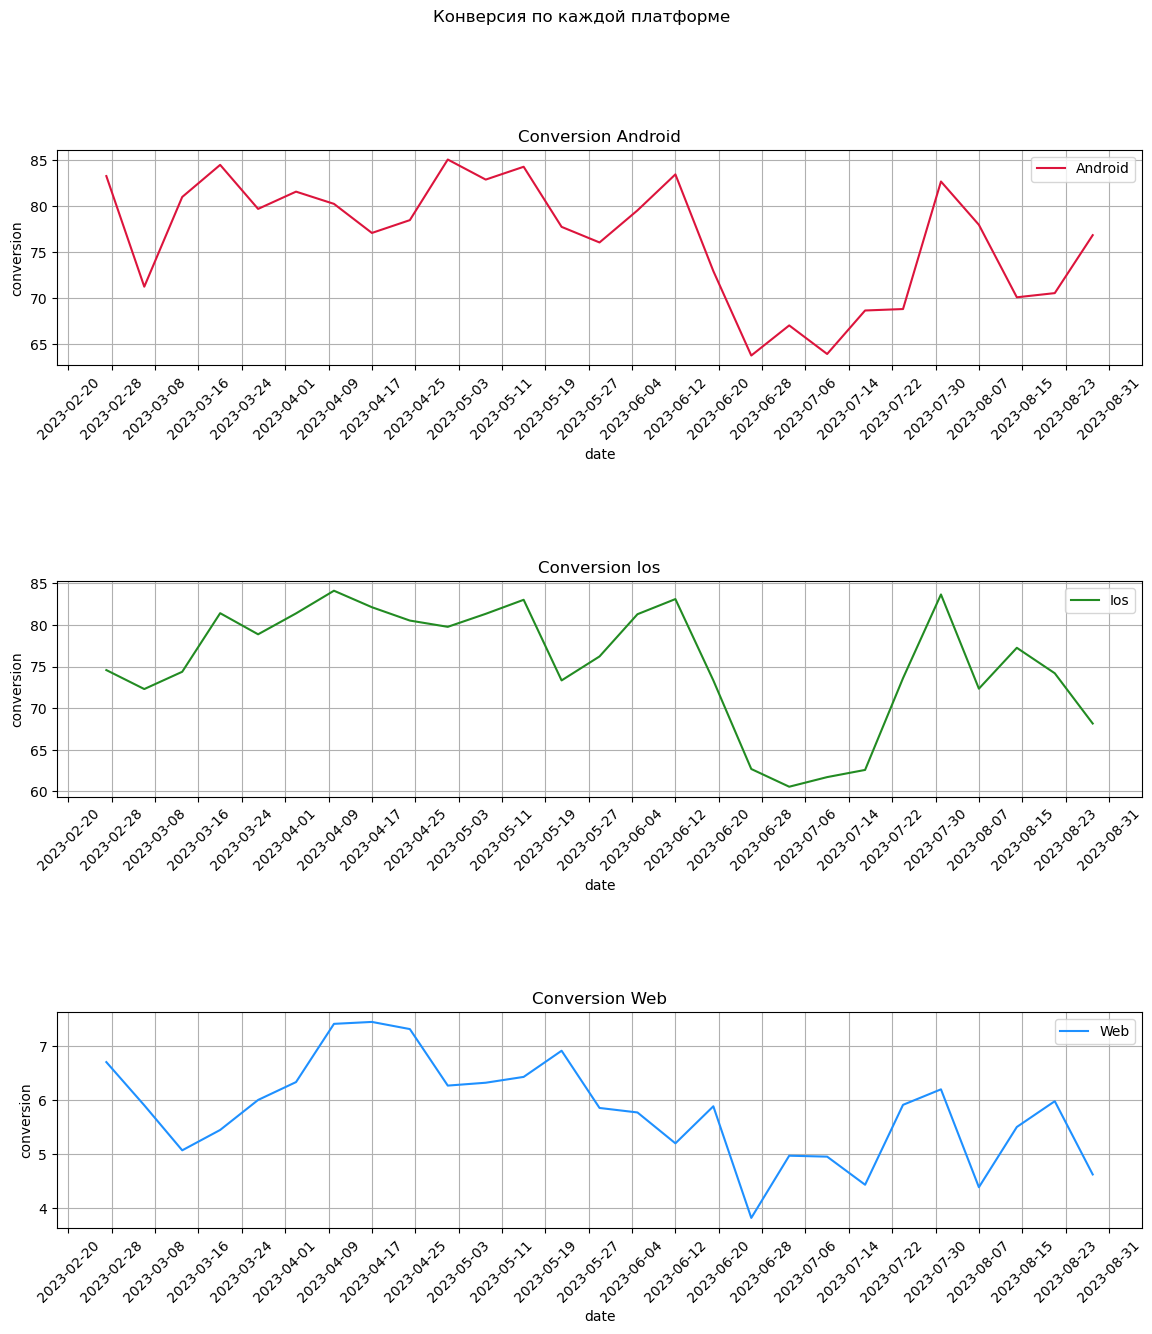

In [244]:
android = grouped_platform[grouped_platform['platform'] == 'android']
ios = grouped_platform[grouped_platform['platform'] == 'ios']
web = grouped_platform[grouped_platform['platform'] == 'web']

fig, axes = plt.subplots(3, 1, sharex=False, sharey=False)
fig.set_size_inches(14, 14)
fig.subplots_adjust(wspace=1.5, hspace=1)
fig.suptitle('Конверсия по каждой платформе', fontsize=12)

axes[0].plot(android['date'], android['conversion'], label='Android', color='crimson')
axes[0].legend()
axes[0].set_title('Conversion Android')
axes[0].set_xlabel('date')
axes[0].set_ylabel('conversion')
axes[0].tick_params(axis='x', rotation=45) 
axes[0].xaxis.set_major_locator(plt.MaxNLocator(nbins=30))
axes[0].grid()


axes[1].plot(ios['date'], ios['conversion'], label='Ios', color='forestgreen')
axes[1].legend()
axes[1].set_title('Conversion Ios')
axes[1].set_xlabel('date')
axes[1].set_ylabel('conversion')
axes[1].tick_params(axis='x', rotation=45) 
axes[1].xaxis.set_major_locator(plt.MaxNLocator(nbins=30))
axes[1].grid()

axes[2].plot(web['date'], web['conversion'], label='Web', color='dodgerblue')
axes[2].legend()
axes[2].set_title('Conversion Web')
axes[2].set_xlabel('date')
axes[2].set_ylabel('conversion')
axes[2].tick_params(axis='x', rotation=45) 
axes[2].xaxis.set_major_locator(plt.MaxNLocator(nbins=30))
axes[2].grid()

plt.savefig('./charts/conversion_by_platform.png')
plt.show()

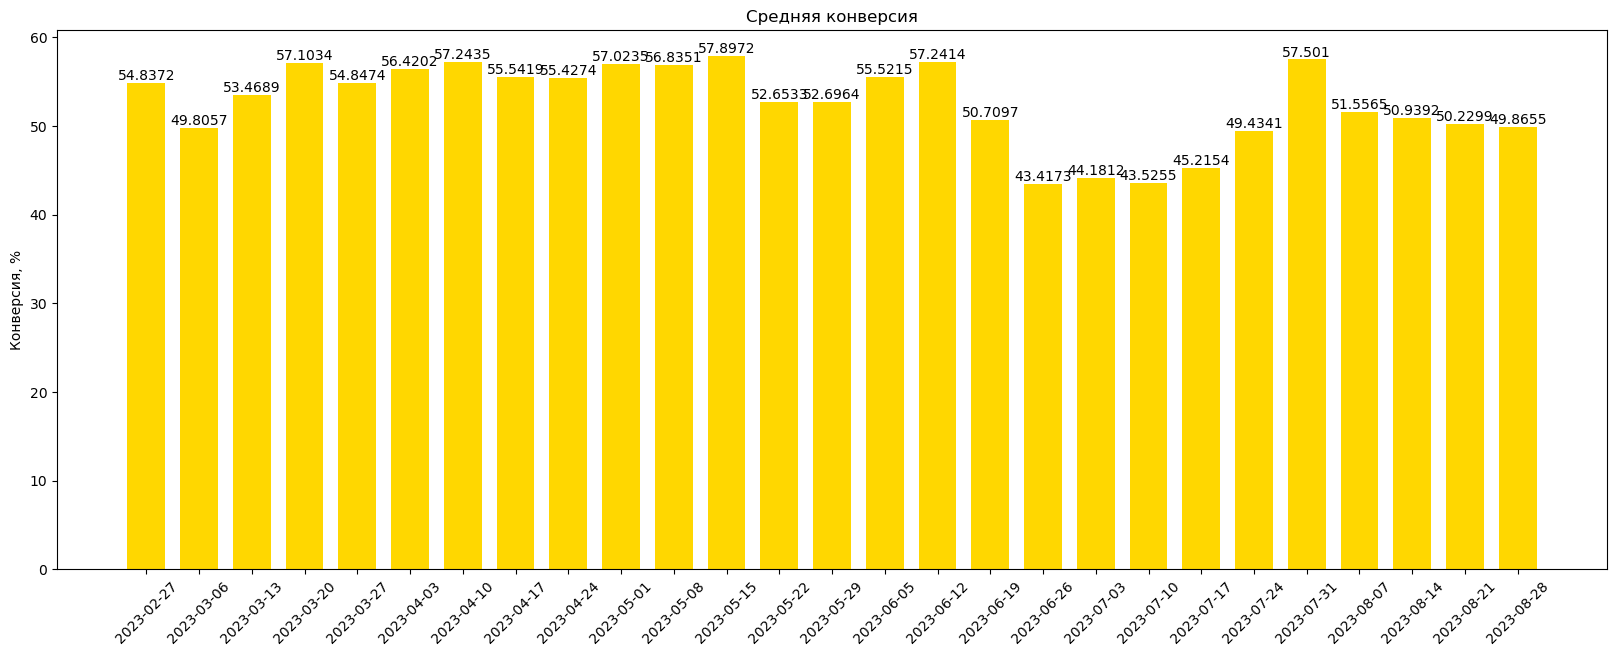

In [246]:
grouped_mean_conv = grouped_platform.groupby('date')['conversion'].mean().reset_index()

fig, ax = plt.subplots(figsize=(20, 7))
plt.bar(grouped_mean_conv['date'], grouped_mean_conv['conversion'], color='gold', width=5)
plt.title('Средняя конверсия')
plt.ylabel('Конверсия, %')
plt.xticks(grouped_mean_conv['date'], rotation=45)
for bars in ax.containers:
    ax.bar_label(bars)
plt.savefig('./charts/average_conversion.png')
plt.show()

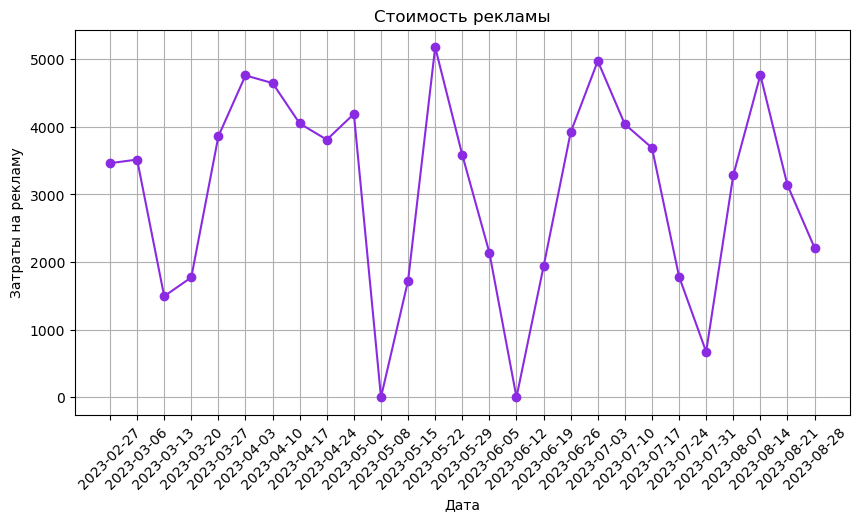

In [248]:
adcosts = grouped_date.groupby('date')['cost'].mean().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(adcosts['date'], adcosts['cost'], color='blueviolet', marker="o")
plt.title('Стоимость рекламы')
plt.xlabel('Дата')
plt.ylabel('Затраты на рекламу')
plt.xticks(adcosts['date'], rotation=45)
plt.grid()
plt.savefig('./charts/advertising_costs.png')
plt.show()

In [231]:
conv_week = df.copy()
conv_week['date_week'] = pd.to_datetime(conv_week['date_group'])
conv_week['date_week'] = conv_week['date_week'].dt.to_period('W').dt.start_time.dt.date
conv_week = conv_week.groupby(['date_week', 'utm_campaign']).sum(['visits', 'registrations', 'cost']).reset_index()
conv_week['conversion'] = (conv_week['registrations'] / conv_week['visits']) * 100
conv_week.head()

,date_week,utm_campaign,visits,registrations,conversion,cost
0,2023-02-27,advanced_algorithms_series,3026,574,18.968936,3462.0
1,2023-03-06,advanced_algorithms_series,8615,1184,13.743471,3516.0
2,2023-03-13,advanced_algorithms_series,3065,438,14.290375,1494.0
3,2023-03-20,virtual_reality_workshop,1078,172,15.955473,1773.0
4,2023-03-27,virtual_reality_workshop,4958,856,17.265026,3861.0


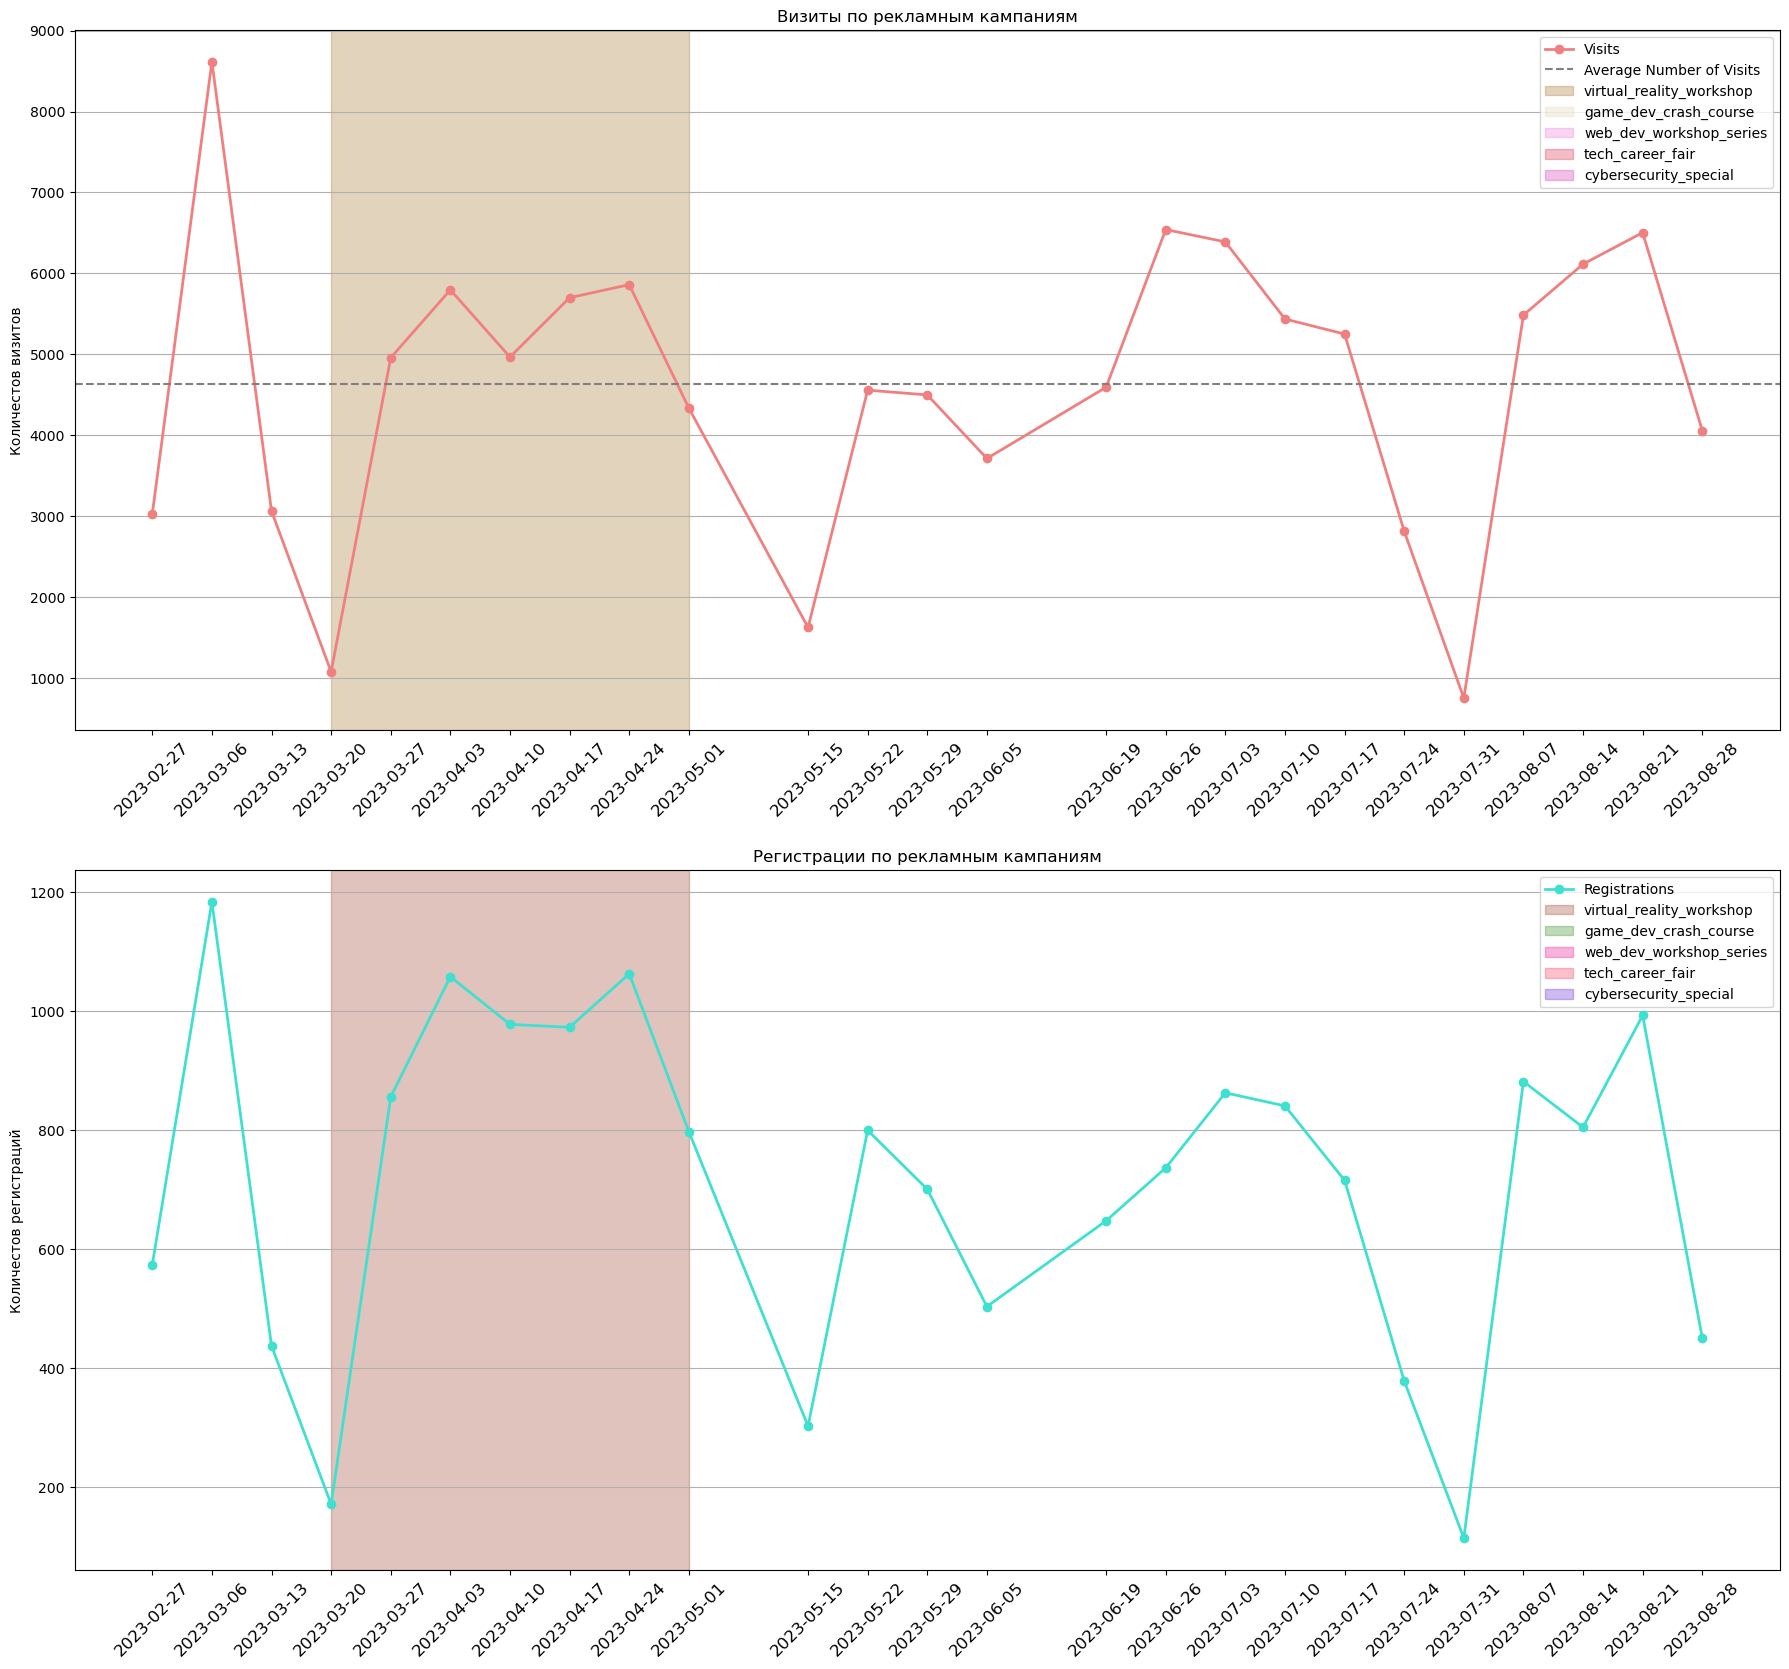

In [265]:
campaign_days = conv_week[['date_week', 'utm_campaign']]
virtual_reality_workshop = campaign_days.loc[campaign_days['utm_campaign'] == 'virtual_reality_workshop']
start_date = virtual_reality_workshop['date_week'].min()
end_date = virtual_reality_workshop['date_week'].max()

game_dev_crash_course = campaign_days.loc[campaign_days['utm_campaign'] == 'game_dev_crash_course']
start_date = game_dev_crash_course['date_week'].min()
end_date = game_dev_crash_course['date_week'].max()

web_dev_workshop_series = campaign_days.loc[campaign_days['utm_campaign'] == 'web_dev_workshop_series']
start_date = web_dev_workshop_series['date_week'].min()
end_date = web_dev_workshop_series['date_week'].max()

tech_career_fair = campaign_days.loc[campaign_days['utm_campaign'] == 'tech_career_fair']
start_date = tech_career_fair['date_week'].min()
end_date = tech_career_fair['date_week'].max()

cybersecurity_special = campaign_days.loc[campaign_days['utm_campaign'] == 'cybersecurity_special']
start_date = cybersecurity_special['date_week'].min()
end_date = cybersecurity_special['date_week'].max()    

periods_of_ads = pd.DataFrame(columns=['start_date', 'end_date', 'utm_campaign'])
periods_of_ads['start_date'] = [virtual_reality_workshop['date_week'].min(), game_dev_crash_course['date_week'].min(), web_dev_workshop_series['date_week'].min(), tech_career_fair['date_week'].min(), cybersecurity_special['date_week'].min()]
periods_of_ads['end_date'] = [virtual_reality_workshop['date_week'].max(), game_dev_crash_course['date_week'].max(), web_dev_workshop_series['date_week'].max(), tech_career_fair['date_week'].max(), cybersecurity_special['date_week'].max()]
periods_of_ads['utm_campaign'] = ['virtual_reality_workshop', 'game_dev_crash_course', 'web_dev_workshop_series', 'tech_career_fair', 'cybersecurity_special']


def vis_regist_campaign_chart(df):
    fig, axes = plt.subplots(2, 1, figsize=(22,20))
    visits_campaign = df.groupby(['date_week'])['visits'].sum().reset_index()
    x = visits_campaign['date_week']
    y = visits_campaign['visits']
    axes[0].plot(x, y,
            marker="o",
            c="lightcoral",
            label='Visits',
            linewidth=2,
            markersize=6)
    avg_visits = df['visits'].mean()
    axes[0].axhline(y=avg_visits, color='gray', linestyle='dashed', label='Average Number of Visits')
    ads_started = periods_of_ads['start_date'].to_list()
    ads_ended = periods_of_ads['end_date'].to_list()
    for i in range(len(ads_started)):
        axes[0].axvspan(ads_started[i], ads_ended[i], alpha=0.3, color=np.random.rand(3,), label=periods_of_ads['utm_campaign'].to_list()[i])
    axes[0].set_title('Визиты по рекламным кампаниям')
    axes[0].set_ylabel('Количестов визитов')
    axes[0].set_xticks(visits_campaign['date_week'])
    axes[0].set_xticklabels(visits_campaign['date_week'], fontsize=12, rotation=45)
    axes[0].legend()
    axes[0].grid(axis='y')
    registr_campaign = conv_week.groupby(['date_week'])['registrations'].sum().reset_index()
    x3 = registr_campaign['date_week']
    y3 = registr_campaign['registrations']
    axes[1].plot(x3, y3,
            marker="o",
            c="turquoise",
            label='Registrations',
            linewidth=2,
            markersize=6)
    avg_registrations = final_df['registrations'].mean()
    for i in range(len(ads_started)):
        axes[1].axvspan(ads_started[i], ads_ended[i], alpha=0.3, color=np.random.rand(3,), label=periods_of_ads['utm_campaign'].to_list()[i])
    axes[1].set_title('Регистрации по рекламным кампаниям')
    axes[1].set_ylabel('Количестов регистраций')
    axes[1].set_xticks(registr_campaign['date_week'])
    axes[1].set_xticklabels(registr_campaign['date_week'], fontsize=12, rotation=45)
    axes[1].legend()
    axes[1].grid(axis='y')
    plt.savefig('./charts/registrations_and_registartions.png')
vis_regist_campaign_chart(conv_week)

In [252]:
grouped_platform.head()

,date,platform,visits,registrations,conversion,cost
0,2023-02-27,android,328,273,83.231707,1154.0
1,2023-02-27,ios,177,132,74.576271,1154.0
2,2023-02-27,web,2521,169,6.703689,1154.0
3,2023-03-06,android,733,522,71.214188,1172.0
4,2023-03-06,ios,296,214,72.297297,1172.0


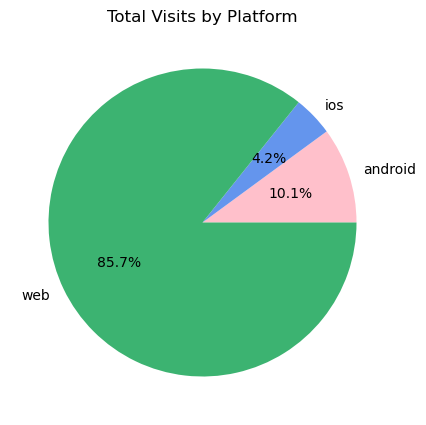

In [264]:
sum_visits = grouped_platform.groupby('platform')['visits'].sum()
colors = ["pink", "cornflowerblue", "mediumseagreen"]

plt.figure(figsize=(5, 5))
plt.pie(sum_visits, labels=sum_visits.index, autopct='%1.1f%%', colors=colors)
plt.title('Total Visits by Platform') 
plt.show()